In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample

In [2]:
data = pd.read_csv('../../datasets/FER2013/fer2013.csv')

In [3]:
def show_image(im_nb):
    pixels = data['pixels'].iloc[im_nb]
    label = data['emotion'].iloc[im_nb] 
    image_array = np.fromstring(pixels, dtype=np.uint8, sep=' ').reshape(48, 48)
    
    cv2.imshow('Image', image_array)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(label)

In [4]:
show_image(2)

2


| Index | Émotion   |
|-------|-----------|
| 0     | Angry     |
| 1     | Disgust   |
| 2     | Fear      |
| 3     | Happy     |
| 4     | Sad       |
| 5     | Surprise  |
| 6     | Neutral   |


In [5]:
def preprocess_images(data):
    images = []
    labels = data['emotion'].values

    for pixel_sequence in data['pixels']:
        single_image = np.fromstring(pixel_sequence, dtype=int, sep=' ')
        single_image = single_image.reshape(48, 48) 
        images.append(single_image)

    images = np.array(images, dtype='float32')
    images = np.expand_dims(images, -1)  # Additional dimension for channels
    images /= 255.0  # Standardization (value between 0 and 1)

    return images, labels

In [6]:
images, labels = preprocess_images(data)

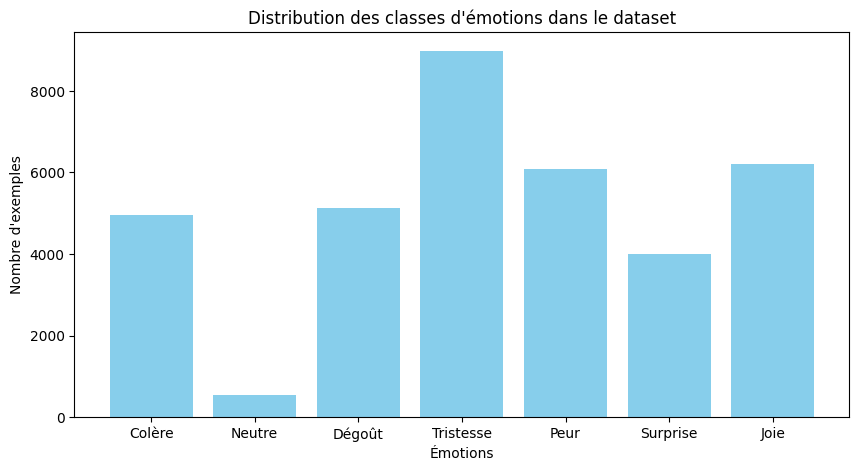

In [7]:
emotions = labels
label_counts = Counter(emotions)

# Préparer les données pour le graphique
emotions, counts = zip(*label_counts.items())

# Créer le graphique
plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])  # Ajuster en fonction des étiquettes spécifiques du dataset
plt.show()

In [8]:
def undersample_data(images, labels):
    # Convertir les labels en array numpy si ce n'est pas déjà le cas
    labels = np.array(labels)
    
    # Trouver le nombre d'exemples dans la classe minoritaire
    min_class_size = np.min([sum(labels == i) for i in np.unique(labels)])
    
    # Créer une liste pour stocker les nouveaux ensembles rééquilibrés
    undersampled_images = []
    undersampled_labels = []
    
    # Rééquilibrer chaque classe
    for label in np.unique(labels):
        # Extraire les images et labels de la classe actuelle
        class_images = images[labels == label]
        class_labels = labels[labels == label]
        
        # Sous-échantillonner la classe si nécessaire
        class_images_undersampled, class_labels_undersampled = resample(class_images, class_labels, 
                                                                        replace=False, 
                                                                        n_samples=min_class_size, 
                                                                        random_state=42)
        
        # Ajouter les données sous-échantillonnées à la liste
        undersampled_images.extend(class_images_undersampled)
        undersampled_labels.extend(class_labels_undersampled)
    
    return np.array(undersampled_images), np.array(undersampled_labels)

In [9]:
images_resample, labels_resample = undersample_data(images, labels)

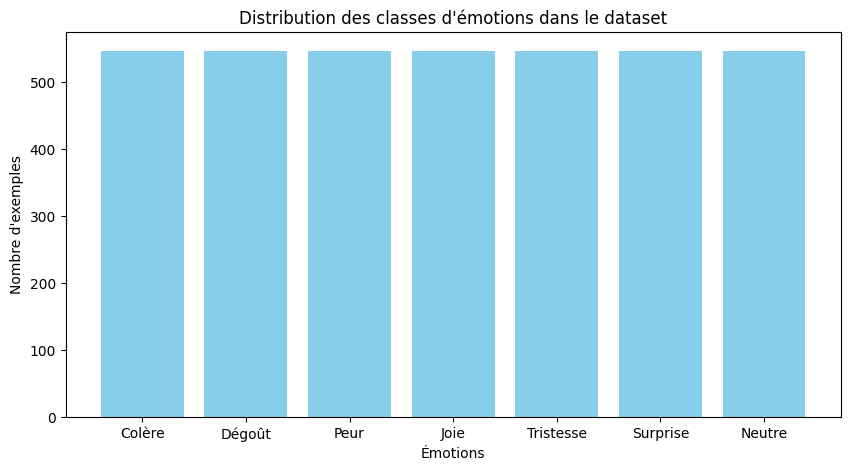

In [10]:
emotions = labels_resample
label_counts = Counter(emotions)

# Préparer les données pour le graphique
emotions, counts = zip(*label_counts.items())

# Créer le graphique
plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])  # Ajuster en fonction des étiquettes spécifiques du dataset
plt.show()